In [1]:
import os
import shutil
import enjoyml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from joblib import dump, load

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
set_session(tf.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from keras import layers, models, optimizers, callbacks, regularizers

### Read data

In [5]:
DATA_PATH = 'data/aclImdb/'

def read_data(data_path):
    sentences, labels = [], []
    dir_label_to_int = {'neg/': 0 , 'pos/': 1}
    for dir_label in dir_label_to_int.keys():  
        data_label_path  = data_path + dir_label
        label = dir_label_to_int[dir_label]
        for file_name in tqdm(os.listdir(data_label_path)):
            with open(data_label_path + file_name, 'r+') as data_file:
                sentense = data_file.read()
                sentences.append(sentense), labels.append(label)
    return sentences, labels


train_sentences, train_labels = read_data(DATA_PATH + 'train/')
test_sentences, test_labels = read_data(DATA_PATH + 'test/')

100%|██████████| 12500/12500 [00:00<00:00, 28409.10it/s]


In [6]:
'aafdsa  faafads    fsdaf   '.split()

['aafdsa', 'faafads', 'fsdaf']

In [7]:
VOCAB_PATH = DATA_PATH + 'imdb.vocab'

vocab_encode_dict = {}
with open(VOCAB_PATH, 'r+') as vocab_file:
    for i, token_line in enumerate(vocab_file):
        token = token_line.replace('\n', '')
        vocab_encode_dict[token] = i


filter_tokens=('?', '.', ',', '!', '<br>', '<br/>', 
               '\'', '"', '(', ')', '<br', '/>', ';', 
               ':', '-')

def replace_chars(s, replaced_chars, new_char):
    for char in replaced_chars:
        s = s.replace(char, new_char)
    return s

def encode_with_vocab(sentences, filter_tokens=filter_tokens, verbosity=0):
    sentences_encoded = []
    for sentense in tqdm(sentences):
        tokens = replace_chars(sentense, filter_tokens, ' ').split()
        tokens_encoded = []
        for token in tokens:
            token = token.lower()
            if token in vocab_encode_dict:
                tokens_encoded.append(vocab_encode_dict[token])
            elif verbosity:
                print(token)
        sentences_encoded.append(tokens_encoded)
    return sentences_encoded

train_sentences_encoded = encode_with_vocab(train_sentences) # , verbosity=1
test_sentences_encoded = encode_with_vocab(test_sentences)

100%|██████████| 25000/25000 [00:03<00:00, 8289.27it/s]


In [8]:
len(vocab_encode_dict)

89527

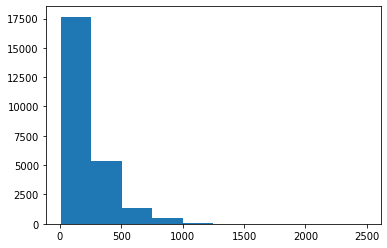

In [9]:
plt.hist(list(map(lambda sents: len(sents), train_sentences_encoded)))
plt.show()

In [10]:
from keras.preprocessing.sequence import pad_sequences

train_sentences_encoded_padded = pad_sequences(train_sentences_encoded, maxlen=500,
                                               padding='post', truncating='post')
train_labels = np.asarray(train_labels)
test_sentences_encoded_padded = pad_sequences(test_sentences_encoded, maxlen=500,
                                              padding='post', truncating='post')
test_labels = np.asarray(test_labels)

In [11]:
train_sentences_encoded_padded.shape

(25000, 500)

In [12]:
train_indexes = np.arange(train_labels.shape[0])
np.random.shuffle(train_indexes)
train_sentences_encoded_padded = train_sentences_encoded_padded[train_indexes]
train_labels = train_labels[train_indexes]

test_indexes = np.arange(test_labels.shape[0])
np.random.shuffle(test_indexes)
test_sentences_encoded_padded = test_sentences_encoded_padded[test_indexes]
test_labels = test_labels[test_indexes]

In [13]:
# train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
#                                               test_size=0.07, stratify=work_labels, random_state=42)
# # train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
# #                                               test_size=0.50, stratify=work_labels, random_state=42)

# print(train_indixes.shape, val_indexes.shape)

In [14]:
# fc_model_full = get_fc_model(28)

# fc_model_full.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer='adam')
# lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
#                                          min_lr=1e-15, min_delta=0.03, verbose=1)
# stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, 
#                                   verbose=1, restore_best_weights=True)

# fc_model_full.fit(work_features_matrix/255, work_labels_encoded,
#                   batch_size=256, epochs=150,
#                   callbacks=[lr_reducer, stopper])

# fc_model.fit(train_features_matrix/255, train_labels_encoded,
#              batch_size=256, epochs=150,
#              validation_data=(val_features_matrix/255, val_labels_encoded),
#              callbacks=[lr_reducer, stopper])

In [15]:
train_labels[:16]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1])

### Рекурентная сеть с векторизацией через индекс в словаре

In [17]:
def get_model():
    x = input_ = layers.Input((None, 1,))
    
    x = layers.Bidirectional(layers.GRU(32, dropout=0.2,
                                        return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(64, dropout=0.2,))(x)
    
#     x = layers.Flatten()(x)
    
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_, outputs=output)
    
    return model

model = get_model()
model.compile(optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc']) # lr=1e-4
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          6528      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               49536     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1644

In [17]:
model.fit(
    train_sentences_encoded_padded[:, :, np.newaxis]/len(vocab_encode_dict), train_labels,
    epochs=20,
    batch_size=256,
    validation_split=0.15,
)

Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 90s 4ms/step - loss: 0.6934 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.5040
Epoch 2/20
21250/21250 [==============================] - 80s 4ms/step - loss: 0.6932 - acc: 0.5072 - val_loss: 0.6968 - val_acc: 0.5021
Epoch 3/20
21250/21250 [==============================] - 81s 4ms/step - loss: 0.6934 - acc: 0.5048 - val_loss: 0.6929 - val_acc: 0.5032
Epoch 4/20
21250/21250 [==============================] - 81s 4ms/step - loss: 0.6934 - acc: 0.5029 - val_loss: 0.6930 - val_acc: 0.5032
Epoch 5/20
21250/21250 [==============================] - 81s 4ms/step - loss: 0.6932 - acc: 0.5048 - val_loss: 0.6930 - val_acc: 0.5032
Epoch 6/20
 6400/21250 [========>.....................] - ETA: 53s - loss: 0.6931 - acc: 0.5097

KeyboardInterrupt: 

In [18]:
model.evaluate(test_sentences_encoded_padded[:, :, np.newaxis]/len(vocab_encode_dict), test_labels)

25000/25000 [==============================] - 186s 7ms/step


[0.6932748725128174, 0.5008800029754639]

### Рекурентная сеть с обучаемым эмбедингом

In [21]:
def get_model():
    x = input_ = layers.Input((None,))
    
    x = layers.Embedding(len(vocab_encode_dict), 8)(x) #
    x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(32))(x)
    
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_, outputs=output)
    
    return model

model = get_model()
model.compile(optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy']) # lr=1e-4
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 8)           716216    
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 32)          2400      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                12480     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0   

In [22]:
model.fit(
    train_sentences_encoded_padded, train_labels,
    epochs=4,
    batch_size=256,
    validation_split=0.15,
)

Train on 21250 samples, validate on 3750 samples
Epoch 1/4
21250/21250 [==============================] - 85s 4ms/step - loss: 0.6688 - accuracy: 0.5746 - val_loss: 0.5443 - val_accuracy: 0.7328
Epoch 2/4
21250/21250 [==============================] - 83s 4ms/step - loss: 0.4030 - accuracy: 0.8306 - val_loss: 0.3928 - val_accuracy: 0.8325
Epoch 3/4
21250/21250 [==============================] - 84s 4ms/step - loss: 0.2578 - accuracy: 0.9103 - val_loss: 0.3916 - val_accuracy: 0.8456
Epoch 4/4
21250/21250 [==============================] - 83s 4ms/step - loss: 0.1492 - accuracy: 0.9511 - val_loss: 0.4223 - val_accuracy: 0.8512


In [23]:
model.evaluate(test_sentences_encoded_padded, test_labels)

25000/25000 [==============================] - 185s 7ms/step


[0.5142109258317947, 0.8200799822807312]

### Сверточная сеть с обучаемым эмбедингом

In [37]:
def get_model():
    x = input_ = layers.Input((500,))
    
    x = layers.Embedding(len(vocab_encode_dict), 16)(x)
    
    x = layers.Conv1D(32, 7, activation='relu')(x)
    x = layers.Conv1D(32, 7, activation='relu')(x)
    x = layers.MaxPool1D(3)(x)
    
    x = layers.Conv1D(64, 7, activation='relu')(x)
    x = layers.Conv1D(64, 7, activation='relu')(x)
    x = layers.MaxPool1D(3)(x)
    
    x = layers.Flatten()(x)
        
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_, outputs=output)
    
    return model

model = get_model()
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc']) # lr=1e-4
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 500, 16)           1432432   
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 494, 32)           3616      
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 488, 32)           7200      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 162, 32)           0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 156, 64)           14400     
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 150, 64)           287

In [38]:
model.fit(
    train_sentences_encoded_padded, train_labels,
    epochs=30,
    batch_size=256,
    validation_split=0.15,
)

Train on 21250 samples, validate on 3750 samples
Epoch 1/30
21250/21250 [==============================] - 2s 116us/step - loss: 0.6930 - acc: 0.5113 - val_loss: 0.6933 - val_acc: 0.5061
Epoch 2/30
21250/21250 [==============================] - 1s 67us/step - loss: 0.6925 - acc: 0.5171 - val_loss: 0.6927 - val_acc: 0.5147
Epoch 3/30
21250/21250 [==============================] - 1s 67us/step - loss: 0.6914 - acc: 0.5279 - val_loss: 0.6934 - val_acc: 0.4992
Epoch 4/30
21250/21250 [==============================] - 1s 67us/step - loss: 0.6670 - acc: 0.6077 - val_loss: 0.7229 - val_acc: 0.5181
Epoch 5/30
21250/21250 [==============================] - 1s 67us/step - loss: 0.5636 - acc: 0.7185 - val_loss: 0.6056 - val_acc: 0.6672
Epoch 6/30
21250/21250 [==============================] - 1s 67us/step - loss: 0.4630 - acc: 0.7866 - val_loss: 0.6214 - val_acc: 0.6949
Epoch 7/30
21250/21250 [==============================] - 1s 67us/step - loss: 0.3871 - acc: 0.8315 - val_loss: 0.5971 - val_acc

In [39]:
model.evaluate(test_sentences_encoded_padded, test_labels)

25000/25000 [==============================] - 2s 68us/step


[0.7341040785074234, 0.8327199816703796]

### Загрузка Glove

In [16]:
GLOVE_DIR = 'data/glove.6b/'
GLOVE_EMBEDDING_DIM = 100

unk_word_embedding = np.zeros(GLOVE_EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_DIR + f'glove.6B.{GLOVE_EMBEDDING_DIM}d.txt') as glove_file:
    for i, line in tqdm(enumerate(glove_file)):
        word, *word_embedding = line.split()
        word_embedding = np.array(word_embedding, dtype='float32')
        embeddings_index[word] = word_embedding
        unk_word_embedding += word_embedding
    unk_word_embedding = unk_word_embedding / i

embedding_matrix = np.zeros((len(vocab_encode_dict), GLOVE_EMBEDDING_DIM))
for word, i in vocab_encode_dict.items():
    embedding_vector = embeddings_index.get(word, unk_word_embedding)
    embedding_matrix[i] = embedding_vector

400000it [00:09, 44084.14it/s]


### Рекурентная сеть с предобученныи эмбедингом Glove

In [49]:
def get_model():
    x = input_ = layers.Input((None,))
    
    x = layers.Embedding(len(vocab_encode_dict), GLOVE_EMBEDDING_DIM)(x)
#     x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, activation='relu'))(x)
    x = layers.Bidirectional(layers.GRU(128, activation='relu'))(x)
    
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_, outputs=output)
    
    return model

model = get_model()

model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

model.compile(optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy']) # lr=1e-4
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, None, 100)         8952700   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, None, 256)         175872    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 256)               295680    
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0  

In [50]:
model.fit(
    train_sentences_encoded_padded, train_labels,
    epochs=20,  # 8 + 4 + 6
    batch_size=256,
    validation_split=0.15,
) 

Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 82s 4ms/step - loss: 0.6867 - accuracy: 0.5349 - val_loss: 0.6504 - val_accuracy: 0.6291
Epoch 2/20
21250/21250 [==============================] - 81s 4ms/step - loss: 0.5600 - accuracy: 0.7153 - val_loss: 0.6616 - val_accuracy: 0.7171
Epoch 3/20
21250/21250 [==============================] - 82s 4ms/step - loss: 0.4457 - accuracy: 0.8089 - val_loss: 0.4386 - val_accuracy: 0.8016
Epoch 4/20
21250/21250 [==============================] - 81s 4ms/step - loss: 0.3810 - accuracy: 0.8414 - val_loss: 0.4102 - val_accuracy: 0.8136
Epoch 5/20
21250/21250 [==============================] - 80s 4ms/step - loss: 0.3415 - accuracy: 0.8596 - val_loss: 0.3800 - val_accuracy: 0.8381
Epoch 6/20
21250/21250 [==============================] - 80s 4ms/step - loss: 0.3173 - accuracy: 0.8714 - val_loss: 0.3290 - val_accuracy: 0.8581
Epoch 7/20
21250/21250 [==============================] - 81s 4ms/ste

In [51]:
model.evaluate(test_sentences_encoded_padded, test_labels)

25000/25000 [==============================] - 183s 7ms/step


[0.3951938766169548, 0.8788800239562988]

### Сверточная сеть  с предобученныи эмбедингом Glove

In [29]:
def get_model():
    x = input_ = layers.Input((500,))
    
    x = layers.Embedding(len(vocab_encode_dict), GLOVE_EMBEDDING_DIM)(x)
    
    x = layers.Conv1D(128, 7, activation='relu')(x)
    x = layers.Conv1D(128, 7, activation='relu')(x)
    x = layers.MaxPool1D(7)(x)
    
    x = layers.Conv1D(256, 7, activation='relu')(x)
    x = layers.Conv1D(256, 7, activation='relu')(x)
    x = layers.MaxPool1D(7)(x)
    
    x = layers.Flatten()(x)
        
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.35)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_, outputs=output)
    
    return model

model = get_model()

model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])  # Adam()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 500, 100)          8952700   
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 494, 128)          89728     
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 488, 128)          114816    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 69, 128)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 63, 256)           229632    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 57, 256)           4590

In [30]:
model.fit(
    train_sentences_encoded_padded, train_labels,
    epochs=30,
    batch_size=256,
    validation_split=0.15,
)

Train on 21250 samples, validate on 3750 samples
Epoch 1/30
21250/21250 [==============================] - 6s 276us/step - loss: 0.6918 - acc: 0.5288 - val_loss: 0.6700 - val_acc: 0.5880
Epoch 2/30
21250/21250 [==============================] - 6s 264us/step - loss: 0.6540 - acc: 0.6174 - val_loss: 1.0156 - val_acc: 0.4893
Epoch 3/30
21250/21250 [==============================] - 6s 264us/step - loss: 0.6147 - acc: 0.6705 - val_loss: 1.1474 - val_acc: 0.4896
Epoch 4/30
21250/21250 [==============================] - 6s 264us/step - loss: 0.5876 - acc: 0.6996 - val_loss: 1.0485 - val_acc: 0.4997
Epoch 5/30
21250/21250 [==============================] - 6s 264us/step - loss: 0.5615 - acc: 0.7173 - val_loss: 0.7101 - val_acc: 0.6144
Epoch 6/30
21250/21250 [==============================] - 6s 265us/step - loss: 0.5387 - acc: 0.7363 - val_loss: 0.4965 - val_acc: 0.7589
Epoch 7/30
21250/21250 [==============================] - 6s 265us/step - loss: 0.5199 - acc: 0.7491 - val_loss: 0.8523 - v

In [31]:
model.evaluate(test_sentences_encoded_padded, test_labels)

25000/25000 [==============================] - 4s 152us/step


[0.34823826424121856, 0.8514800071716309]

### DeepMoji

#### pretrained

In [16]:
import sys
# sys.path.pop()
sys.path.append('/home/ataleckij/Projects/university/MO_4sem/laba7/deepmoji')
sys.path.append('/home/ataleckij/Projects/university/MO_4sem/laba7/deepmoji/deepmoji')
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/ataleckij/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/ataleckij/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/ataleckij/.ipython',
 '/home/ataleckij/Projects/university/MO_4sem/laba7/deepmoji',
 '/home/ataleckij/Projects/university/MO_4sem/laba7/deepmoji/deepmoji']

In [17]:
import json
from deepmoji.sentence_tokenizer import SentenceTokenizer
from deepmoji.model_def import deepmoji_emojis
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

maxlen = 500

with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)
st = SentenceTokenizer(vocabulary, maxlen)

model = deepmoji_emojis(maxlen, PRETRAINED_PATH)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 256)     12800000    input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 500, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 500, 1024)    3149824     activation_1[0][0]             

In [18]:
test_sentences_tokenized, _, _ = st.tokenize_sentences(test_sentences)

In [20]:
test_predict = model.predict(test_sentences_tokenized)

In [26]:
np.unique(test_predict.argmax(axis=1))

array([ 0,  4,  5,  8,  9, 11, 12, 13, 14, 16, 19, 21, 22, 24, 25, 27, 28,
       30, 31, 32, 33, 34, 37, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

#### fit from scratch

In [49]:
from deepmoji.model_def import deepmoji_architecture

nb_tokens = len(vocab_encode_dict)#20000
# maxlen = 250
batch_size = 32

model = deepmoji_architecture(nb_classes=2, nb_tokens=nb_tokens, maxlen=maxlen)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 256)     22918912    input_14[0][0]                   
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 500, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 500, 1024)    3149824     activation_19[0][0]              
___________________________________________________________________________________________

In [50]:
# from keras.utils import to_categorical

# train_labels_cat = to_categorical(train_labels, num_classes=2, dtype='float32')
# test_labels_cat = to_categorical(test_labels, num_classes=2, dtype='float32')`

In [51]:
model.fit(train_sentences_encoded_padded, train_labels, 
          batch_size=batch_size, epochs=2,
          validation_split=0.15)

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21250/21250 [==============================] - 1124s 53ms/step - loss: 0.3935 - accuracy: 0.8260 - val_loss: 0.3020 - val_accuracy: 0.8813
Epoch 2/2
21250/21250 [==============================] - 1126s 53ms/step - loss: 0.2098 - accuracy: 0.9277 - val_loss: 0.3095 - val_accuracy: 0.8848


In [52]:
model.evaluate(test_sentences_encoded_padded, test_labels)

25000/25000 [==============================] - 311s 12ms/step


[0.34343218544244764, 0.8657199740409851]